In [1]:
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
import time
from pathlib import Path
import os

# Self-written modules
from yq.scripts import models
from yq.scripts import heston_func
from yq.utils import option
from yq.utils import calendar
from yq.scripts import simulation as sm
from sc import constants as cs
from sy.variance_reduction import apply_control_variates
from sy.interest_rate import populate_bond_table, get_period
from sy.calibration import apply_empirical_martingale_correction

/Users/tangyiqwan/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Acads/4_Y4S1/MH4518/group-project/code/simulation-in-finance/code/yq/scripts/heston_func.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [3]:
print(cs.ASSET_NAMES)

['LONN.SW', 'SIKA.SW']


# Fetch stock data

[*********************100%%**********************]  2 of 2 completed


,LONN.SW,SIKA.SW
Date,,
2023-10-16,426.100006,235.000000
2023-10-17,357.299988,222.199997
2023-10-18,344.700012,216.300003
2023-10-19,342.000000,218.199997
2023-10-20,332.899994,217.000000
2023-10-23,327.600006,215.899994
2023-10-24,330.899994,215.699997
2023-10-25,315.000000,212.000000
2023-10-26,315.899994,211.199997


331.3999938964844

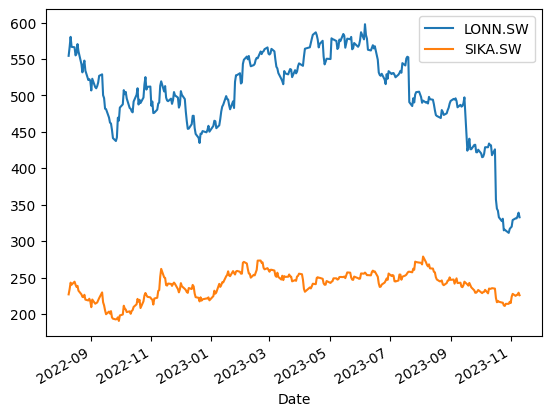

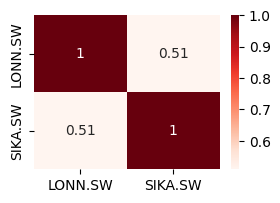

In [2]:
historical_start_date = '2022-08-09'
# Define the ticker list
ticker_list = ['LONN.SW', 'SIKA.SW']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
display(data.tail(20))
data.plot()
display(data.loc['2023-11-07']['LONN.SW'])

plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [3]:
params = {
    'data': data,
    'ticker_list': ['LONN.SW', 'SIKA.SW']
}
trading_calendar = calendar.SIXTradingCalendar()
gbm = models.PricingModel(params = params)

Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))


Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Total sims/length of sim_data_df for 2023-08-09 00:00:00: 100
Total sims/length of sim_data_df for 2023-08-10 00:00:00: 0
Total days is: 2

list[0]


/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_88313/1201944831.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


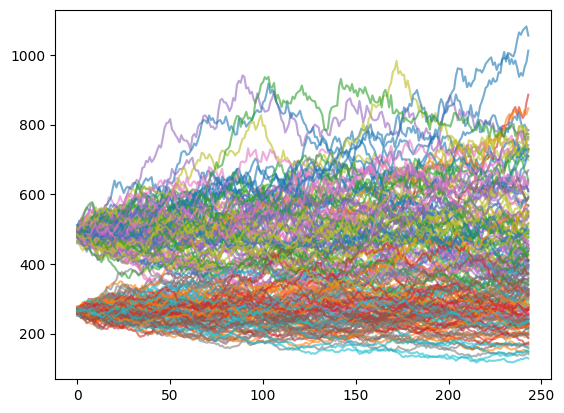

In [9]:
# Copy the start_time_str from the folders
product_est_date_sim_data_df_list = sm.read_sim_data(
        model_name='gbm',
        start_time_str='20231110_233950_693680', 
        prod_est_start_date=pd.Timestamp('2023-08-09'), 
        prod_est_end_date=pd.Timestamp('2023-08-10'))
print(type(product_est_date_sim_data_df_list)[0])
n_sim_on_day = pd.concat(product_est_date_sim_data_df_list[0], axis=1)
ax = n_sim_on_day.plot(alpha=0.6, legend=False)
ax.figure.show()


In [8]:
bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-08-09')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
n_sim = 100
for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()

        sim_data_df = []
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=0)
            sim_data_df.append(sim_data)
            
            sm.store_sim_data(start_time_acc=start_time_acc,
                           model_name='gbm',
                           sim_data=sim_data,
                           product_est_date=product_est_date,
                           sim=sim)

        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")
    
    
    # TODO: Tag the sim_data with the dates
    # TODO: Add the concate the yfinance data from initial fixing date to the sim_data
    # TODO: Break the df into 2 df, each with date as one of the columns (not the index) for sc payoff function
    # Get the data?

    
    # TODO: Store the payoff df to the class and plot?

# TODO: Implement the second simulation with the control variate method? Another loop or same loop?

# sim_data.columns = ["simulated_" + ticker for ticker in ticker_list]

# A dataframe with both validation data and simulated data


Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
909
910
Z matrix is 
[-0.8046  0.3669]

Z matrix is 
[1.5896 0.3279]

Z matrix is 
[0.7992 0.295 ]

Z matrix is 
[-0.206  -0.0392]

Z matrix is 
[ 0.3764 -1.4938]

Z matrix is 
[ 0.785  -0.8372]

Z matrix is 
[-1.296  2.26 ]

Z matrix is 
[ 0.5433 -0.6906]

Z matrix is 
[ 1.5324 -0.3091]

Z matrix is 
[-0.327  -0.0956]

Z matrix is 
[-2.3794  0.5203]

Z matrix is 
[0.7057 0.6155]

Z matrix is 
[ 1.2801 -0.1659]

Z matrix is 
[-2.0571 -1.8308]

Z matrix is 
[-1.1236 -1.814 ]

Z matrix is 
[-1.8423  2.0023]

Z matrix is 
[-1.4301 -1.5006]

Z matrix is 
[-1.3705 -1.1598]

Z matrix is 
[ 0.0876 -0.097 ]

Z matrix is 
[0.1665 0.1   ]

Z ma

In [6]:
# Variance reduction
today = pd.Timestamp('2023-08-09')
r = 0.0167
# calculate means
s_01  = 1
s_02 = 1.2
mu1 = s_01 * np.exp(r*(cs.FINAL_FIXING_DATE - today).days/252)
mu2 = s_02 * np.exp(r*(cs.FINAL_FIXING_DATE  - today).days/252)
print(mu1, mu2)


Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
909
910
/Users/tangyiqwan/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Acads/4_Y4S1/MH4518/group-project/code/simulation-in-finance
/Users/tangyiqwan/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Acads/4_Y4S1/MH4518/group-project/code/simulation

AttributeError: 'NoneType' object has no attribute 'plot'

In [ ]:
# TODO pass me ST for lonn and sika as payoffs
# payoffs_cv = apply_control_variates(__place_holder__, __place_holder__, mu1, mu2, payoffs)

In [5]:
# bond table
path = '../data/bond'

bond_yield = None
for file in os.listdir(path):
   df = pd.read_csv(os.path.join(path, file))[['Date','Price']]
   df.rename(columns={'Price':file.split(' ')[1]}, inplace=True)
   df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
   df = df.set_index('Date').iloc[::-1]
   if bond_yield is None:
      bond_yield = df
   else:
      bond_yield = pd.concat([bond_yield, df], axis=1)
bond_yield = bond_yield.interpolate()
bond_yield = bond_yield.reindex(sorted(bond_yield.columns, key=lambda x: get_period(x)), axis=1) # sort index
bond_yield

,1-Week,1-Month,2-Month,3-Month,6-Month,1-Year,2-Year
Date,,,,,,,
2022-01-01,-1.00,-0.80,-0.78,-0.95,-0.90,-0.80,NaN
2022-01-02,-1.00,-0.77,-0.76,-0.90,-0.85,-0.80,NaN
2022-01-03,-0.88,-0.84,-0.87,-0.86,-0.85,-0.80,-0.700
2022-01-04,-0.90,-0.86,-0.74,-0.86,-0.85,-0.73,-0.729
2022-01-05,-0.94,-0.87,-0.80,-0.87,-0.85,-0.73,-0.715
...,...,...,...,...,...,...,...
2023-11-05,1.60,1.60,1.64,1.62,1.60,1.70,1.330
2023-11-06,1.58,1.59,1.64,1.61,1.65,1.67,1.326
2023-11-07,1.58,1.59,1.63,1.61,1.65,1.67,1.338


In [6]:
bond_price = pd.DataFrame(index=bond_yield.index)
for col in bond_yield.columns:
    bond_price[col] = bond_yield[col].apply(lambda x: np.exp(-x/100*get_period(col)))
bond_price

,1-Week,1-Month,2-Month,3-Month,6-Month,1-Year,2-Year
Date,,,,,,,
2022-01-01,1.000192,1.000667,1.001301,1.002378,1.004510,1.008032,NaN
2022-01-02,1.000192,1.000642,1.001267,1.002253,1.004259,1.008032,NaN
2022-01-03,1.000169,1.000700,1.001451,1.002152,1.004259,1.008032,1.014098
2022-01-04,1.000173,1.000717,1.001234,1.002152,1.004259,1.007327,1.014687
2022-01-05,1.000181,1.000725,1.001334,1.002177,1.004259,1.007327,1.014403
...,...,...,...,...,...,...,...
2023-11-05,0.999692,0.998668,0.997270,0.995958,0.992032,0.983144,0.973751
2023-11-06,0.999696,0.998676,0.997270,0.995983,0.991784,0.983439,0.973829
2023-11-07,0.999696,0.998676,0.997287,0.995983,0.991784,0.983439,0.973595


In [7]:
bond_table = populate_bond_table(bond_price, cs.FINAL_FIXING_DATE)
bond_table

,price
Date,
2022-01-01,NaN
2022-01-02,NaN
2022-01-03,1.014098
2022-01-04,1.014687
2022-01-05,1.014403
...,...
2023-11-05,0.987868
2023-11-06,0.98792
2023-11-07,0.987966
